In [2]:
import earthaccess
import geopandas as gpd
import h5py
import numpy as np
import pandas as pd
import pygmt
import pystac_client
import rioxarray  # noqa: F401
import shapely.geometry
import stackstac
#import torch
import tqdm

In [3]:
earthaccess.login()

Enter your Earthdata Login username:  Jehayes
Enter your Earthdata password:  ········


In [4]:
GEDI_results= earthaccess.search_data(
    short_name='GEDI02_B',
    version='002',
    cloud_hosted=True,
    bounding_box=(-121.83183686310275, 39.251634434878014, -120.00653085351905, 40.2087274330508),
    temporal=("2019-08-01", "2019-09-01"),
    count=3
)

In [5]:
GEDI_results

[Collection: {'ShortName': 'GEDI02_B', 'Version': '002'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -158.6015651135, 'Latitude': -0.0100300309}, {'Longitude': -140.539844646, 'Latitude': 23.3566009965}, {'Longitude': -137.8749561776, 'Latitude': 26.2013941876}, {'Longitude': -135.0681660582, 'Latitude': 28.9826371402}, {'Longitude': -132.0968864286, 'Latitude': 31.6894485361}, {'Longitude': -128.9338646389, 'Latitude': 34.3091107961}, {'Longitude': -125.5598770797, 'Latitude': 36.8259912001}, {'Longitude': -121.9435288734, 'Latitude': 39.2241059194}, {'Longitude': -118.0626455903, 'Latitude': 41.4824080213}, {'Longitude': -113.9006376509, 'Latitude': 43.5846280408}, {'Longitude': -109.4342894506, 'Latitude': 45.5025714683}, {'Longitude': -104.6560518645, 'Latitude': 47.2127155124}, {'Longitude': -99.5683380437, 'Latitude': 48.6878240741}, {'Longitude': -94.1876160397, 'Latitude': 49.9021379921}, {'Longitude': -88.55

In [65]:
import json
import re
import geopandas as gpd
from shapely.geometry import Polygon
# Assume that DataGranule is a class and input_list contains instances of this class
class DataGranule:
    def __init__(self, data):
        self.data = data

    def __str__(self):
        return self.data
        # Convert each DataGranule object to its string representation
input_str = ''.join(str(item) for item in GEDI_results)
# Extract the JSON-like portion of the string using regex
match = re.search(r"\[\{'Longitude':.*?\}\]", input_str)
# If the pattern is found, proceed to convert it into a list of dictionaries
if match:
    spatial_coverage_str = match.group(0)
    # Convert the string to a Python list of dictionaries
    spatial_coverage = json.loads(spatial_coverage_str.replace("'", '"'))
# Now spatial_coverage contains the list of dictionaries with Longitude and Latitude
print(spatial_coverage)
# Convert to a list of tuples (Longitude, Latitude)
coords = [(point['Longitude'], point['Latitude']) for point in spatial_coverage]
# Create a Polygon object
polygon = Polygon(coords)
# Create a GeoDataFrame
GEDI_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])


# Create polygon from user-inputted bounding box
bbox = (-121.83183686310275, 39.251634434878014, -120.00653085351905, 40.2087274330508)
bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), 
                   (bbox[2], bbox[3]), (bbox[2], bbox[1])])
bbox_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[bbox_polygon])

GEDI_clip_poly = gpd.clip(GEDI_gdf, bbox_gdf)
print(GEDI_clip_poly.iloc[0].geometry)

[{'Longitude': -158.6015651135, 'Latitude': -0.0100300309}, {'Longitude': -140.539844646, 'Latitude': 23.3566009965}, {'Longitude': -137.8749561776, 'Latitude': 26.2013941876}, {'Longitude': -135.0681660582, 'Latitude': 28.9826371402}, {'Longitude': -132.0968864286, 'Latitude': 31.6894485361}, {'Longitude': -128.9338646389, 'Latitude': 34.3091107961}, {'Longitude': -125.5598770797, 'Latitude': 36.8259912001}, {'Longitude': -121.9435288734, 'Latitude': 39.2241059194}, {'Longitude': -118.0626455903, 'Latitude': 41.4824080213}, {'Longitude': -113.9006376509, 'Latitude': 43.5846280408}, {'Longitude': -109.4342894506, 'Latitude': 45.5025714683}, {'Longitude': -104.6560518645, 'Latitude': 47.2127155124}, {'Longitude': -99.5683380437, 'Latitude': 48.6878240741}, {'Longitude': -94.1876160397, 'Latitude': 49.9021379921}, {'Longitude': -88.5541352731, 'Latitude': 50.8299319569}, {'Longitude': -82.7236016559, 'Latitude': 51.4511080992}, {'Longitude': -76.7710728305, 'Latitude': 51.7496376902}, {'

<Axes: >

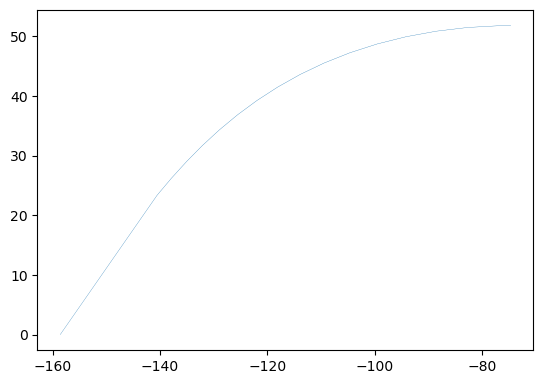

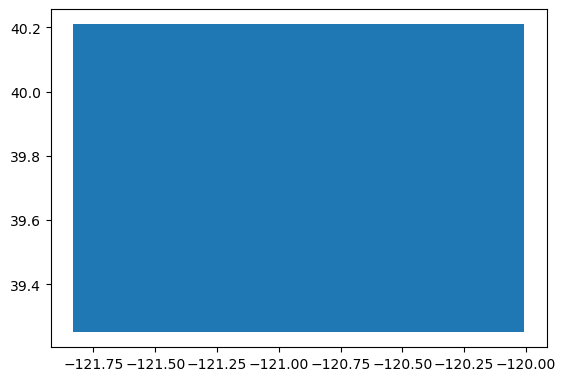

In [71]:
GEDI_gdf.plot()
bbox_gdf.plot()

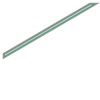

In [66]:
GEDI_clip_poly.iloc[0].geometry

In [77]:
geom = GEDI_clip_poly.iloc[0].geometry
geom.exterior.xy

(array('d', [-121.83183686310275, -121.83183686310275, -120.36021683143657, -120.25146067344878, -121.83183686310275]),
 array('d', [39.28909996411093, 39.35208436432354, 40.2087274330508, 40.2087274330508, 39.28909996411093]))

In [ ]:
x_values = geom.xy[0].tolist()
y_values = geom.boundary.xy[1].tolist()

In [64]:
[(x, y) for x, y in zip(x_values, y_values)]

[(-121.83183686310275, 39.28909996411093),
 (-121.83183686310275, 39.35208436432354),
 (-120.36021683143657, 40.2087274330508),
 (-120.25146067344878, 40.2087274330508),
 (-121.83183686310275, 39.28909996411093)]

In [78]:
import icepyx as ipx
short_name = 'ATL08'
spatial_extent = [(x, y) for x, y in zip(x_values, y_values)]
date_range = ["2019-08-01", "2019-09-01"]
region = ipx.Query(short_name, spatial_extent, date_range)

In [79]:
region.avail_granules(ids=True)

[['ATL08_20190815210225_07450406_006_02.h5',
  'ATL08_20190819205407_08060406_006_02.h5',
  'ATL08_20190821083817_08290402_006_02.h5',
  'ATL08_20190825082958_08900402_006_02.h5']]